# Gereksinimleri yükle

In [ ]:
!pip install gensim transformers nlpaug wordcloud

# İlgili Kütüphaneleri Yükle

In [ ]:
import os
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from gensim.models import Word2Vec

import torch
from transformers import BertTokenizer, BertModel

import nlpaug.augmenter.word as naw

# NLTK veri indirme
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# Dosyaları CSV formatına dönüştür

In [ ]:
# txt dosyalarını csv dosyasına çevirme
def process_files_to_csv(input_dir, output_csv, file_suffix):
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Genre', 'Title', 'Plot'])

        for filename in os.listdir(input_dir):
            if filename.endswith(file_suffix):
                genre = filename.split('_')[0]
                filepath = os.path.join(input_dir, filename)

                with open(filepath, 'r', encoding='utf-8') as file:
                    lines = file.readlines()
                    i = 0
                    while i < len(lines):
                        line = lines[i].rstrip('\n')

                        if line.startswith(('  ', '   ')):
                            title = line.strip()
                            if i + 1 < len(lines):
                                plot = lines[i + 1].strip()
                                writer.writerow([genre, title, plot])
                                i += 2
                            else:
                                i += 1
                        else:
                            i += 1


process_files_to_csv(input_dir='data-nlp/train', output_csv='train.csv', file_suffix='_train.txt') # input_dir parametresine kendi dosya yolunuzu giriniz

process_files_to_csv(input_dir='data-nlp/test', output_csv='test.csv', file_suffix='_test.txt') # input_dir parametresine kendi dosya yolunuzu giriniz

# Ön işleme

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """ Metin ön işleme fonksiyonu """
    text = text.lower()  # Küçük harfe çevirme
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = word_tokenize(text)  # Tokenizasyon
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)


train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Veri setine ön işleme uygulama
train_df["Processed_Plot"] = train_df["Plot"].astype(str).apply(preprocess_text)
test_df["Processed_Plot"] = test_df["Plot"].astype(str).apply(preprocess_text)

<ipython-input-37-72044fa95c50>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x="Genre", order=train_df["Genre"].value_counts().index, palette="viridis")


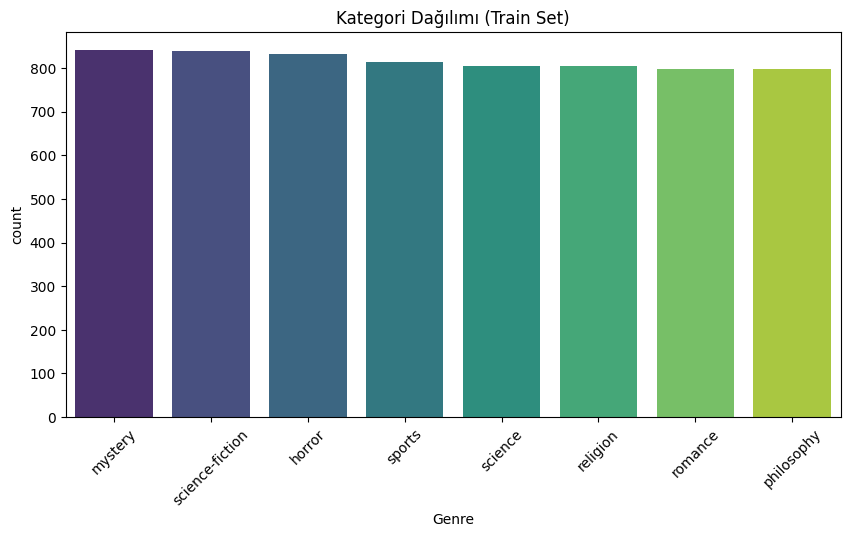

In [ ]:
# 📌 **1. Kategori Dağılımı Görselleştirme**
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x="Genre", order=train_df["Genre"].value_counts().index, palette="viridis")
plt.xticks(rotation=45)
plt.title("Kategori Dağılımı (Train Set)")
plt.show()

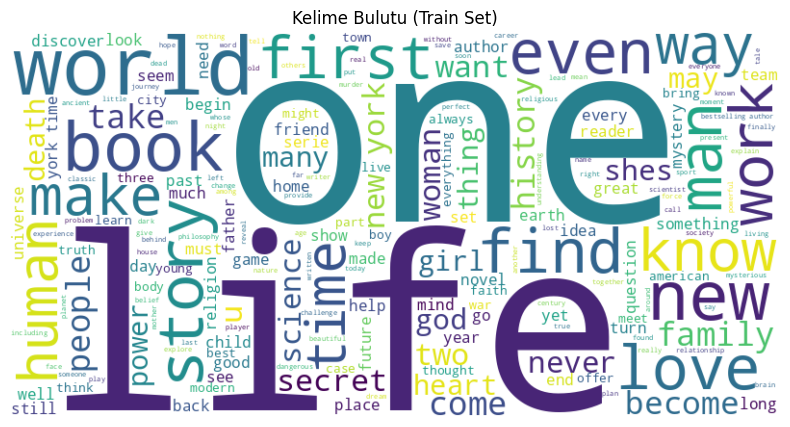

In [ ]:
# 📌 **2. Kelime Bulutu (Word Cloud)**
text_corpus = " ".join(train_df["Processed_Plot"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_corpus)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Kelime Bulutu (Train Set)")
plt.show()

<ipython-input-39-a2498a4cdb1c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_common_words["Count"], y=most_common_words["Word"], palette="magma")


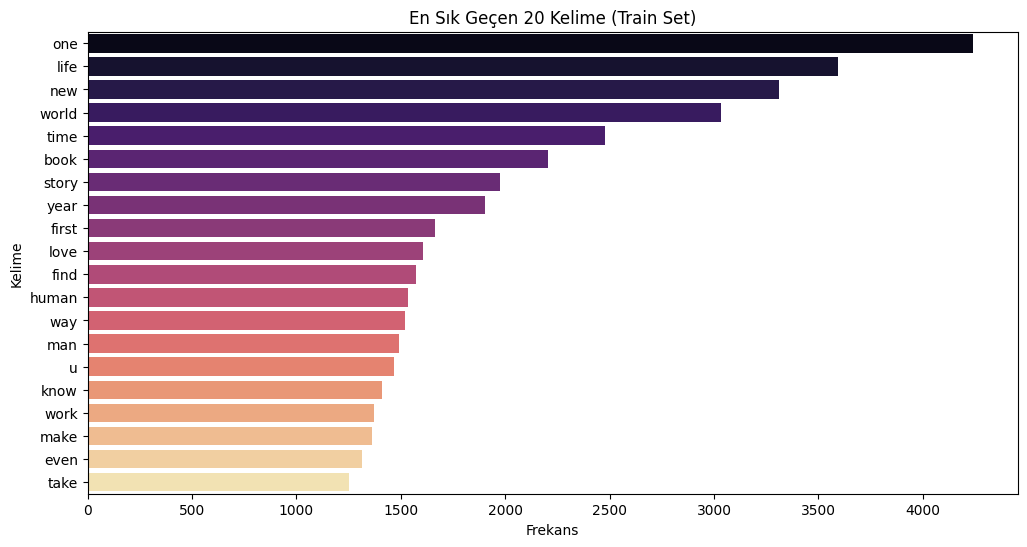

In [ ]:
# 📌 **3. En Çok Geçen Kelimeler**
from collections import Counter
word_counts = Counter(" ".join(train_df["Processed_Plot"]).split())

most_common_words = pd.DataFrame(word_counts.most_common(20), columns=["Word", "Count"])
plt.figure(figsize=(12, 6))
sns.barplot(x=most_common_words["Count"], y=most_common_words["Word"], palette="magma")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.title("En Sık Geçen 20 Kelime (Train Set)")
plt.show()

# Veri Analizi

In [ ]:
import pandas as pd
df1 = pd.read_csv("test.csv")
df2 = pd.read_csv("train.csv")

# Dosyaları birleştir (satır bazında)
birlestirilmis_df = pd.concat([df1, df2], ignore_index=True)

# Birleştirilmiş verileri yeni bir CSV dosyasına kaydet
birlestirilmis_df.to_csv("book_data.csv", index=False)


In [ ]:
df = pd.read_csv("book_data.csv")
df

,Genre,Title,Plot
0,horror,The Haunting of Hill House,It is the story of four seekers who arrive at ...
1,horror,Misery,Alternate cover editions here and here.Paul Sh...
2,horror,The Exorcist,Four decades after it first terrified the worl...
3,horror,The Strange Case of Dr. Jekyll and Mr. Hyde,Strange Case of Dr Jekyll and Mr Hyde is the o...
4,horror,Rosemary's Baby,"Rosemary and Guy Woodhouse, an ordinary young ..."
...,...,...,...
8384,philosophy,Wittgenstein's Mistress,Wittgenstein's Mistress is a novel unlike anyt...
8385,philosophy,The Giving Tree,Once there was a tree...and she loved a little...
8386,philosophy,On the Fourfold Root of the Principle of Suffi...,"A disciple of Immanuel Kant, Arthur Schopenhau..."
8387,philosophy,The God Who Is There,For over thirty years The God Who Is There has...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8389 entries, 0 to 8388
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   8389 non-null   object
 1   Title   8389 non-null   object
 2   Plot    8389 non-null   object
dtypes: object(3)
memory usage: 196.7+ KB


In [ ]:
df.isnull().sum()

,0
Genre,0
Title,0
Plot,0


Text(0, 0.5, 'Count')

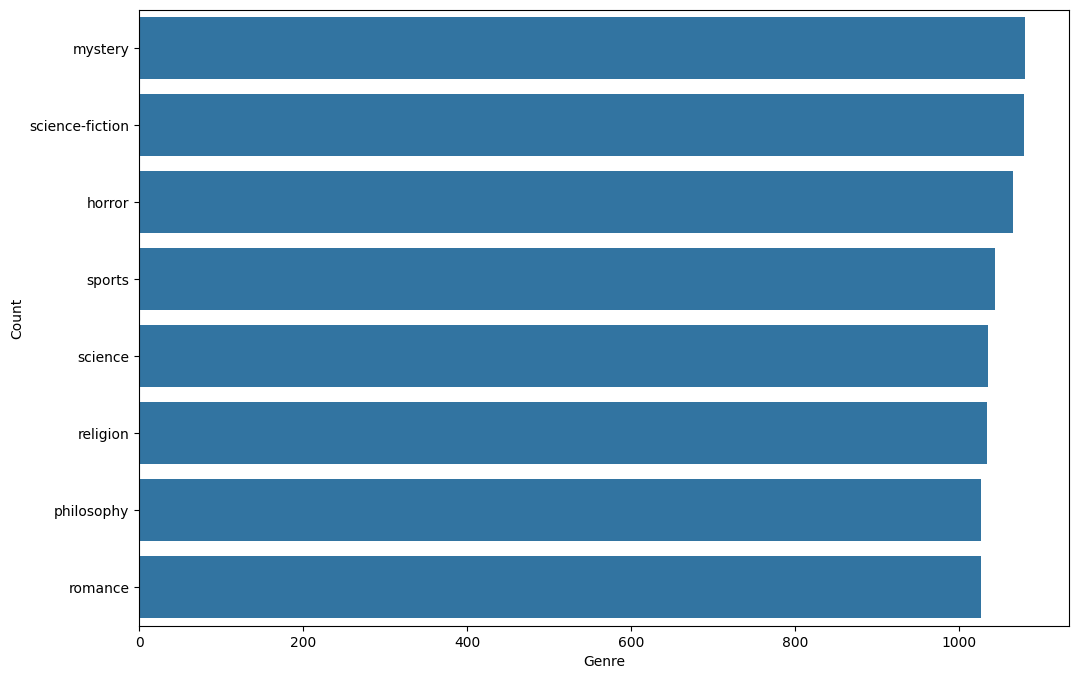

In [ ]:
plt.figure(figsize=(12,8))
counts = df.Genre.value_counts()
sns.barplot(x=counts, y=counts.index, orient='h')
plt.xlabel('Genre')
plt.ylabel('Count')

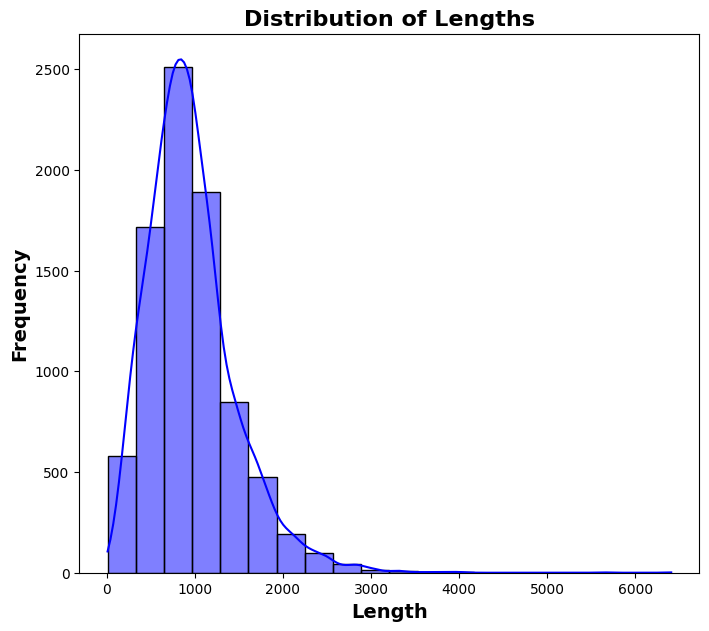

In [ ]:
df['length_Text_cleaning'] = df['Plot'].apply(len)

plt.figure(figsize=(8, 7))
sns.histplot(data=df, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

# BoW

## Adım Adım Uygulama

### 1. Veri Yükleme ve Bölme

In [ ]:
df = pd.read_csv("book_data.csv")

# Veri setini train ve test olarak ayır
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)

### 2. Metin Temizleme

In [ ]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()
    return text

train_df['Plot'] = train_df['Plot'].apply(clean_text)

### 3. Veri Artırma (Data Augmentation)

Her eğitim örneği için:
- Orijinal metni koruyoruz
- Eşanlamlı kelime değiştirme ile yeni bir örnek oluşturuyoruz
- Rastgele kelime silme ile yeni bir örnek oluşturuyoruz

Böylece veri setimizin boyutunu 3 katına çıkarıyoruz.

In [ ]:
# Data Augmentation (Sadece train verisi üzerinde)

# Eşanlamlı Değiştirme
def synonym_replacement(text, n=2):
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_text = aug.augment(text, n=n)
    return augmented_text[0]

# Rastgele Silme
def random_deletion(text, p=0.1):
    words = text.split()
    if len(words) <= 1:
        return text
    new_words = [word for word in words if random.uniform(0, 1) > p]
    if len(new_words) == 0:
        return random.choice(words)
    return ' '.join(new_words)

augmented_texts2 = []
augmented_labels2 = []

# Her bir satır için augmentation (Sadece train)
for text, label in zip(train_df['Plot'], train_df['Genre']):
    # Orijinal metni ekle
    augmented_texts2.append(text)
    augmented_labels2.append(label)

    # Eşanlamlı değiştirme ile augmented metin
    aug_text = synonym_replacement(text, n=2)
    augmented_texts2.append(aug_text)
    augmented_labels2.append(label)

    # Rastgele silme ile augmented metin
    aug_text = random_deletion(text, p=0.1)
    augmented_texts2.append(aug_text)
    augmented_labels2.append(label)

# Yeni veri setini oluşturma
augmented_df2 = pd.DataFrame({
    'text': augmented_texts2,
    'genre': augmented_labels2
})

# Yeni veri setini kontrol etme
print(augmented_df2.head())
print(f"Yeni veri seti boyutu: {len(augmented_df2)}")
augmented_df2.to_csv("augmented_data_train.csv", index=False)

### 4. Metin Vektörizasyonu
Bag of Words (BoW) yaklaşımı ile metinleri en sık kullanılan 5000 kelimeyi içeren vektörlere dönüştürüyoruz.

In [ ]:
vectorizer = CountVectorizer(max_features=5000)
X_train_val = vectorizer.fit_transform(augmented_df2['text']).toarray()
X_test = vectorizer.transform(test_df['Plot'].apply(clean_text)).toarray()

### 5. Etiket Kodlama
Kategorik genre etiketlerini sayısal değerlere dönüştürüp, one-hot encoding uyguluyoruz.

In [ ]:
le = LabelEncoder()
y_train_val = le.fit_transform(augmented_df2['genre'])
y_train_val = to_categorical(y_train_val, num_classes=8)
y_test = le.transform(test_df['Genre'])
y_test = to_categorical(y_test, num_classes=8)

### 6. MLP Modeli

In [ ]:
# modeli train validation olarak ayırıyoruz
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

# erken durdurma kodu
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Optimize edilmiş model (MLP)
mlp_model = Sequential()
mlp_model.add(Input(shape=(5000,)))
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dropout(0.3))
mlp_model.add(Dense(8, activation='softmax'))

# LR ayarlandı
mlp_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Erken durdurma eklendi
history_mlp = mlp_model.fit(X_train, y_train, epochs=50, batch_size=32,
                                    validation_data=(X_val, y_val),
                                    callbacks=[early_stopping])

### 7. LSTM Modeli

In [ ]:
# LSTM için veriyi düzenle
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Optimize edilmiş lstm modeli
lstm_model = Sequential()
lstm_model.add(Input(shape=(1, 5000)))
lstm_model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
lstm_model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
lstm_model.add(Dense(8, activation='softmax'))

# LR ayarlandı
lstm_model.compile(optimizer=Adam(learning_rate=0.0005),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Erken durdurma eklendi
history_lstm = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32,
                                    validation_data=(X_val_lstm, y_val),
                                    callbacks=[early_stopping])

### 8. Model Değerlendirme

In [ ]:
# tahminler
mlp_pred = np.argmax(mlp_model.predict(X_test), axis=1)
lstm_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# MLP sonuçları
mlp_test_loss, mlp_test_acc = mlp_model.evaluate(X_test, y_test, verbose=0)
mlp_precision = precision_score(y_test_labels, mlp_pred, average='macro')
mlp_recall = recall_score(y_test_labels, mlp_pred, average='macro')
mlp_f1 = f1_score(y_test_labels, mlp_pred, average='macro')

print(f"MLP Test Accuracy: {mlp_test_acc:.4f}")
print(f"MLP Precision: {mlp_precision:.4f}")
print(f"MLP Recall: {mlp_recall:.4f}")
print(f"MLP F1-Score: {mlp_f1:.4f}")

# LSTM sonuçları
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_lstm, y_test, verbose=0)
lstm_precision = precision_score(y_test_labels, lstm_pred, average='macro')
lstm_recall = recall_score(y_test_labels, lstm_pred, average='macro')
lstm_f1 = f1_score(y_test_labels, lstm_pred, average='macro')

print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")
print(f"LSTM Precision: {lstm_precision:.4f}")
print(f"LSTM Recall: {lstm_recall:.4f}")
print(f"LSTM F1-Score: {lstm_f1:.4f}")

### 9. Sonuçların Görselleştirilmesi

                                                text       genre
0  based john deweys lectures esthetics delivered...  philosophy
1  based john admiral dewey lectures esthetics de...  philosophy
2  based john lectures esthetics delivered first ...  philosophy
3  centuries scientists written cannibalism bizar...     science
4  centuries scientists written cannibalism bizar...     science
Yeni veri seti boyutu: 21390
Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.1870 - loss: 2.9705 - val_accuracy: 0.6012 - val_loss: 1.2518
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.4253 - loss: 1.6417 - val_accuracy: 0.7381 - val_loss: 0.8284
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.5932 - loss: 1.1394 - val_accuracy: 0.7942 - val_loss: 0.6240
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.6966 - loss: 0.8632 - val_accuracy: 0.8289 - val_loss: 0.5032
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accur

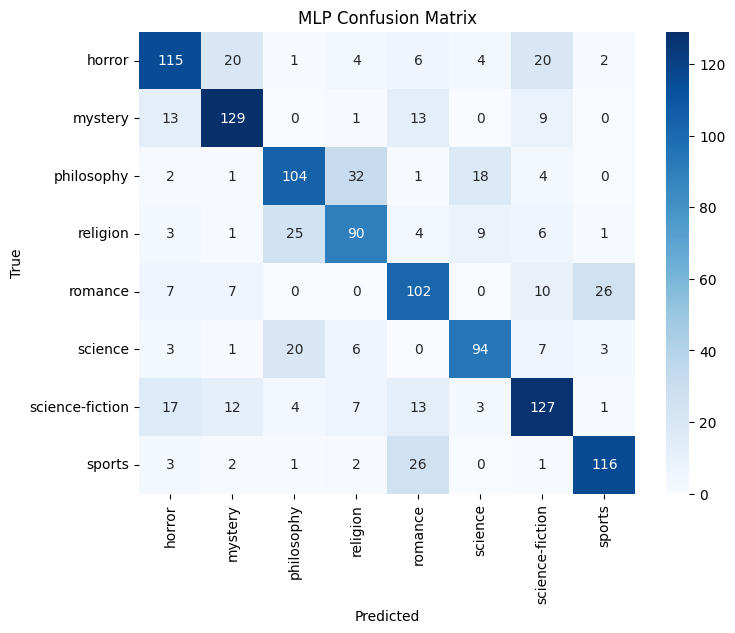

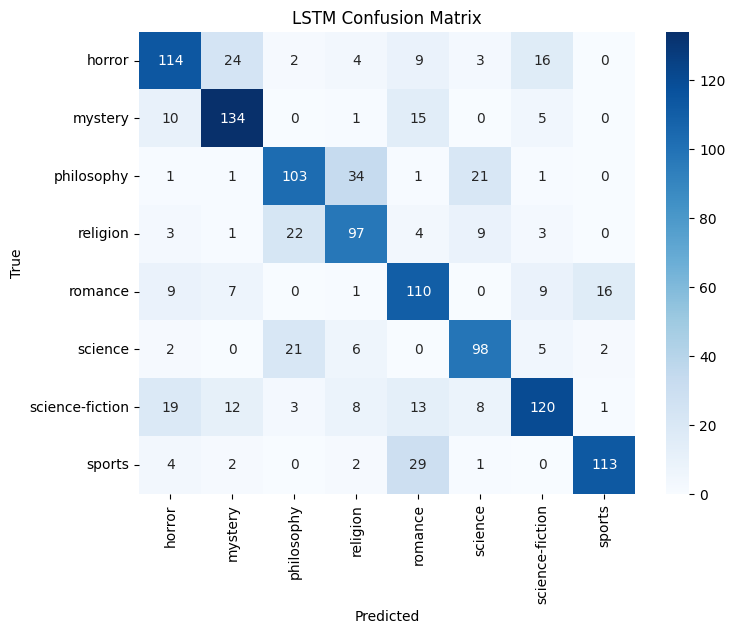

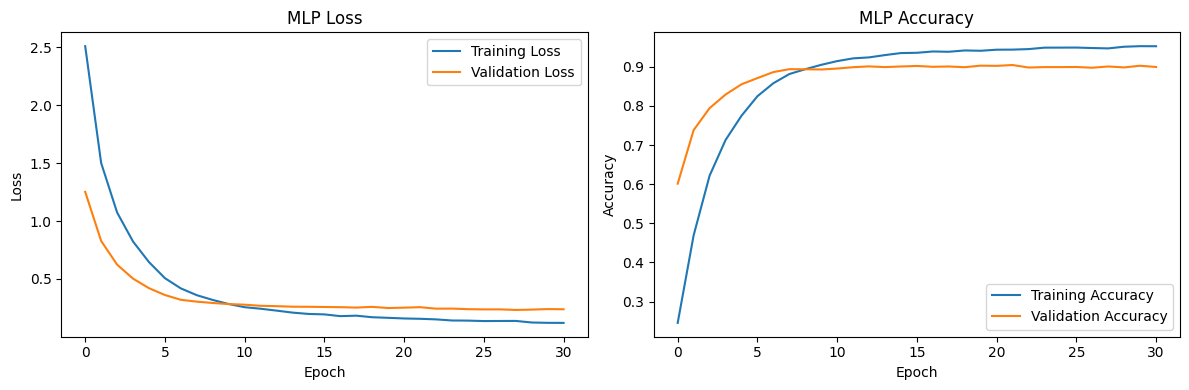

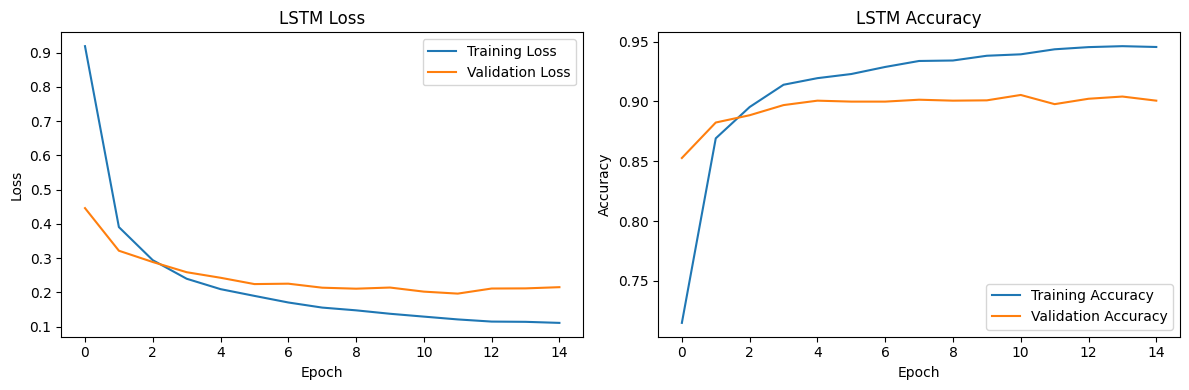

In [ ]:

# MLP Confusion Matrix
mlp_cm = confusion_matrix(y_test_labels, mlp_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# LSTM Confusion Matrix
lstm_cm = confusion_matrix(y_test_labels, lstm_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# MLP Plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['loss'], label='Training Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
plt.title('MLP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['accuracy'], label='Training Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# LSTM Plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# TF-IDF

## Adım Adım Uygulama

### 1. Veri Yükleme ve Bölme

In [ ]:
df = pd.read_csv("book_data.csv")

# Veri setini train ve test olarak ayır
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

### 2. Metin Temizleme Fonksiyonu

In [ ]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()
    return text

### 3. Önceden Hazırlanmış Artırılmış Veri Setini Yükleme
BoW yöntemi yaparken zaten veriyi istediğimiz formatta arttırdık o veri setini yüklüyoruz.

In [ ]:
augmented_df2 = pd.read_csv("augmented_data_train.csv")

### 4. TF-IDF Vektörizasyonu
Bu adımda:
- TF-IDF vektörizasyonu için en fazla 5000 özellik (kelime) kullanılıyor
- Eğitim verilerini TF-IDF ile dönüştürüp matrisi oluşturuyoruz
- Test verilerini aynı vektörizasyon ile dönüştürüyoruz

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_val = tfidf.fit_transform(augmented_df2['text']).toarray()
X_test = tfidf.transform(test_df['Plot'].apply(clean_text)).toarray()

### 5. Etiket Kodlama
Kategorik tür (genre) etiketlerini sayısal değerlere dönüştürüp, one-hot encoding uyguluyoruz.

In [ ]:
le = LabelEncoder()
y_train_val = le.fit_transform(augmented_df2['genre'])
y_train_val = to_categorical(y_train_val, num_classes=8)
y_test = le.transform(test_df['Genre'])
y_test = to_categorical(y_test, num_classes=8)

### 6. Eğitim ve Doğrulama Verilerini Ayırma

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

### 7. MLP Modeli
MLP (Multi-Layer Perceptron) modeli:
- Giriş katmanı: 5000 boyutlu (TF-IDF vektörleri)
- İlk gizli katman: 512 nöron, ReLU aktivasyon, %50 dropout
- İkinci gizli katman: 256 nöron, ReLU aktivasyon, %50 dropout
- Çıkış katmanı: 8 nöron (tür sayısı), softmax aktivasyon

In [ ]:
# Erken durdurma patience 3 yaptık
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# MLP Modeli oluşturuluyor
mlp_model = Sequential()
mlp_model.add(Input(shape=(5000,)))
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(8, activation='softmax'))
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# MLP Modeli eğitiliyor
history_mlp = mlp_model.fit(X_train, y_train, epochs=50, batch_size=32,
                                    validation_data=(X_val, y_val), callbacks=[early_stopping])

### 8. LSTM Modeli
LSTM modeli için:
- Verileri (batch_size, timesteps, features) formatına dönüştürüyoruz
- 128 LSTM birimi, %20 dropout ve recurrent_dropout
- 8 nöron (tür sayısı), softmax aktivasyon

In [ ]:
# LSTM Modeli için veri yeniden şekillendiriliyor
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# LSTM Modeli oluşturuluyor
lstm_model = Sequential()
lstm_model.add(Input(shape=(1, 5000)))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(8, activation='softmax'))
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# LSTM Modeli eğitiliyor
history_lstm = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32,
                                    validation_data=(X_val_lstm, y_val), callbacks=[early_stopping])

### Tahminler ve Görselleştirme

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.5718 - loss: 1.2424 - val_accuracy: 0.8822 - val_loss: 0.3469
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9190 - loss: 0.2600 - val_accuracy: 0.9017 - val_loss: 0.2800
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9350 - loss: 0.1920 - val_accuracy: 0.9020 - val_loss: 0.2530
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9430 - loss: 0.1625 - val_accuracy: 0.9036 - val_loss: 0.2495
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9418 - loss: 0.1512 - val_accuracy: 0.9017 - val_loss: 0.2293
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9461 - loss: 0.1273 - val_accuracy: 0.9012 - val_loss: 0.2143
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9475 - loss: 0.1230 - val_accuracy: 0.9047 - val_loss: 0.2307
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9464 - loss: 0.1188 - 

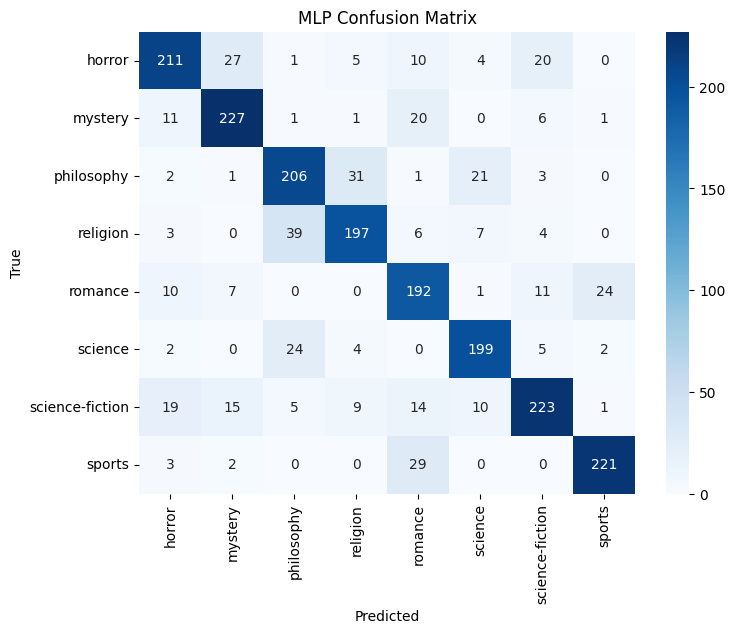

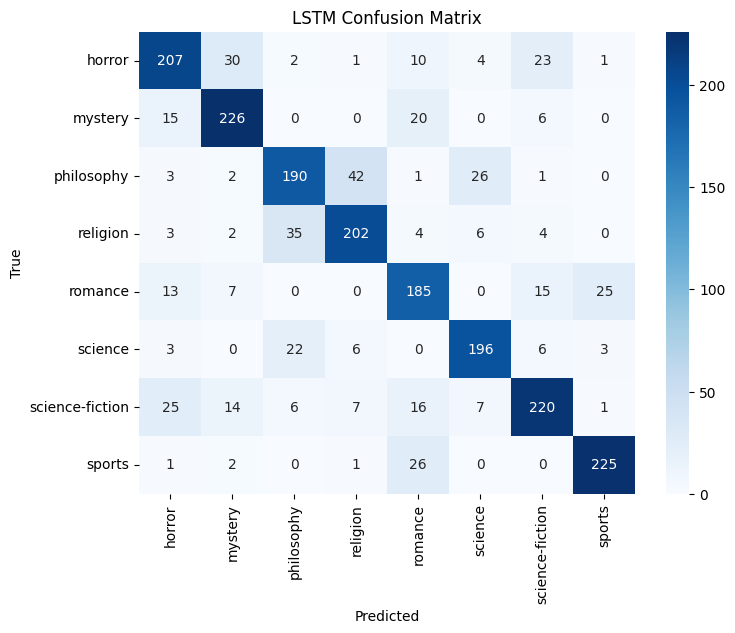

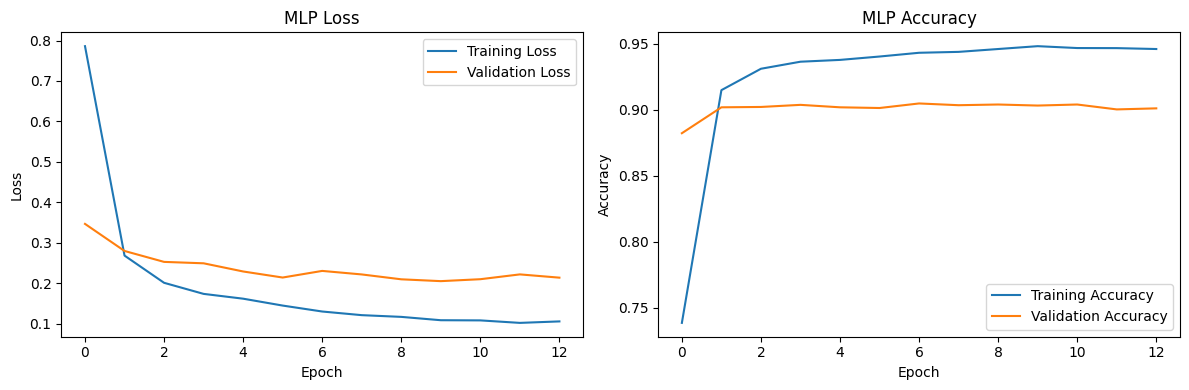

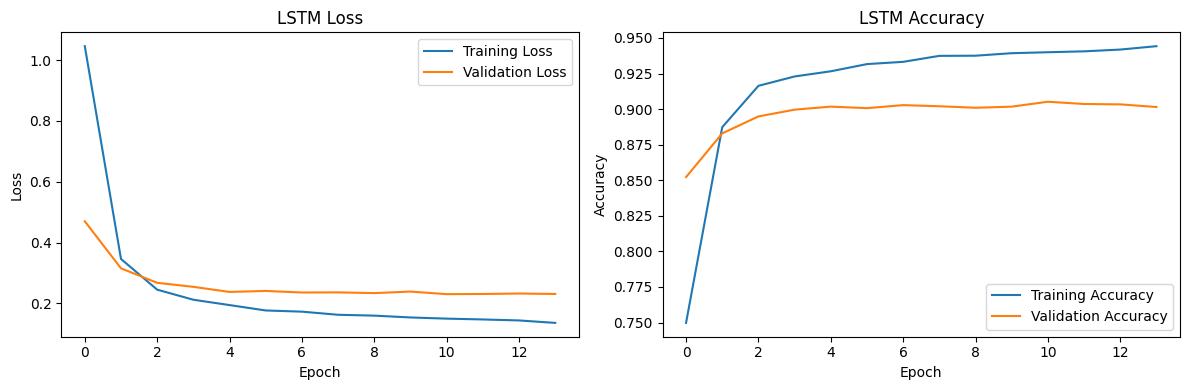

In [ ]:
# tahminler
mlp_pred = np.argmax(mlp_model.predict(X_test), axis=1)
lstm_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# MLP sonuçları
mlp_test_loss, mlp_test_acc = mlp_model.evaluate(X_test, y_test, verbose=0)
mlp_precision = precision_score(y_test_labels, mlp_pred, average='macro')
mlp_recall = recall_score(y_test_labels, mlp_pred, average='macro')
mlp_f1 = f1_score(y_test_labels, mlp_pred, average='macro')

print(f"MLP Test Accuracy: {mlp_test_acc:.4f}")
print(f"MLP Precision: {mlp_precision:.4f}")
print(f"MLP Recall: {mlp_recall:.4f}")
print(f"MLP F1-Score: {mlp_f1:.4f}")

# LSTM sonuçları
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_lstm, y_test, verbose=0)
lstm_precision = precision_score(y_test_labels, lstm_pred, average='macro')
lstm_recall = recall_score(y_test_labels, lstm_pred, average='macro')
lstm_f1 = f1_score(y_test_labels, lstm_pred, average='macro')

print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")
print(f"LSTM Precision: {lstm_precision:.4f}")
print(f"LSTM Recall: {lstm_recall:.4f}")
print(f"LSTM F1-Score: {lstm_f1:.4f}")



# MLP Confusion Matrix
mlp_cm = confusion_matrix(y_test_labels, mlp_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# LSTM Confusion Matrix
lstm_cm = confusion_matrix(y_test_labels, lstm_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# MLP Plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['loss'], label='Training Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
plt.title('MLP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['accuracy'], label='Training Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# LSTM Plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Word2Vec

## 1. Veri Yükleme ve Bölme

In [ ]:
df = pd.read_csv("book_data.csv")

train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)

## 2. Metin Ön İşleme
w2v bağlamsal anlamı yakalayabildiği için fazlalık kelimeleri ya da noktalama işaretlerini kaldırmadık

In [ ]:
def preprocess_text(text):
    # küçük harfe çevir
    text = text.lower()
    # linkleri sil
    text = re.sub(r'http\S+', '', text)
    # fazla boşlukları kaldır
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['cleaned_plot'] = train_df['Plot'].apply(preprocess_text)
test_df['cleaned_plot'] = test_df['Plot'].apply(preprocess_text)

## 3. Veri Artırma Fonksiyonları
İki farklı veri artırma tekniği kullanılıyor:
- **Eş anlamlı kelime değiştirme**: Metindeki n kelimeyi (varsayılan 2) eş anlamlılarıyla değiştiriyor
- **Rastgele silme**: Kelimelerin p olasılıkla (varsayılan 0.1 veya %10) silinmesini sağlıyor

In [ ]:
# eş anlam
def synonym_replacement(text, n=2):
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_text = aug.augment(text, n=n)
    return augmented_text[0]

# Random silme
def random_deletion(text, p=0.1):
    words = text.split()
    if len(words) <= 1:
        return text
    new_words = [word for word in words if random.uniform(0, 1) > p]
    if len(new_words) == 0:
        return random.choice(words)
    return ' '.join(new_words)

## 4. Veri Artırma Uygulaması
Her eğitim örneği için 3 versiyon oluşturuluyor:
1. Orijinal metin
2. Eş anlamlı kelime değiştirilmiş versiyon
3. Rastgele kelime silinmiş versiyon

Bu sayede veri seti 3 katına çıkarılıyor.

In [ ]:
augmented_texts = []
augmented_labels = []


for text, label in zip(train_df['cleaned_plot'], train_df['Genre']):
    # orijinal metni ekle
    augmented_texts.append(text)
    augmented_labels.append(label)

    # eş anlamlı versiyonu ekle
    aug_text = synonym_replacement(text, n=2)
    augmented_texts.append(aug_text)
    augmented_labels.append(label)

    # rasgele silinmiş versiyonu ekle
    aug_text = random_deletion(text, p=0.1)
    augmented_texts.append(aug_text)
    augmented_labels.append(label)

# yeni dataframe oluştur
augmented_df = pd.DataFrame({
    'text': augmented_texts,
    'genre': augmented_labels
})

print(f"Original train data size: {len(train_df)}")
print(f"Augmented data size: {len(augmented_df)}")

## 5. Word2Vec Modeli Eğitimi

In [ ]:
#
augmented_df.to_csv("augmented_data_word2vec.csv", index=False)

# tüm metni tokenize et
augmented_df['tokens'] = augmented_df['text'].apply(word_tokenize)
test_df['tokens'] = test_df['cleaned_plot'].apply(word_tokenize)

word2vec_model = Word2Vec(
    sentences=augmented_df['tokens'].tolist(),
    vector_size=300,  # Kelime vektörlerinin boyutu
    window=5,         # Bağlam pencere boyutu
    min_count=2,      # Minimum kelime sıklığı
    workers=4,        # Paralel çalışacak iş parçacığı sayısı
    sg=1,             # Skip-gram modeli kullanımı (1), CBOW yerine (0)
    epochs=10         # Eğitim dönem sayısı
)

## 6. Doküman Vektörleri
Her doküman için, içerdiği kelimelerin Word2Vec vektörlerinin ortalaması alınarak 300 boyutlu bir doküman vektörü oluşturuluyor.

In [ ]:
def document_vector(doc, model):
    doc = [word for word in doc if word in model.wv.key_to_index]
    if not doc:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in doc], axis=0)

X_train_val = np.array([document_vector(doc, word2vec_model) for doc in augmented_df['tokens']])
X_test = np.array([document_vector(doc, word2vec_model) for doc in test_df['tokens']])

## 7. Etiket Kodlama

In [ ]:
le = LabelEncoder()
y_train_val = le.fit_transform(augmented_df['genre'])
y_train_val = to_categorical(y_train_val)
y_test = le.transform(test_df['Genre'])
y_test = to_categorical(y_test)

num_classes = y_train_val.shape[1]

## 8. Eğitim-Doğrulama Bölme
Artırılmış eğitim veri seti, %75 eğitim ve %25 doğrulama olarak ayrılıyor.

In [ ]:
# Split augmented train into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

## 9. MLP Modeli
MLP modeli, üç gizli katmandan oluşuyor (512, 256 ve 128 nöron). Aşırı öğrenmeyi önlemek için Dropout ve BatchNormalization katmanları kullanılıyor.

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create MLP model
mlp_model = Sequential()
mlp_model.add(Input(shape=(300,)))  # Word2Vec dimension
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dropout(0.3))
mlp_model.add(Dense(num_classes, activation='softmax'))

# Compile MLP model
mlp_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train MLP model
history_mlp = mlp_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

## 10. LSTM Modeli
LSTM modeli, iki LSTM katmanından (256 ve 128 birim) oluşuyor. MLP modelinden farklı olarak, giriş verileri (1, 300) şeklinde yeniden şekillendiriliyor.

In [ ]:
# verileri lstm'e göre düzenle
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# lst modelini oluştur
lstm_model = Sequential()
lstm_model.add(Input(shape=(1, 300)))  # Word2Vec dimension
lstm_model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
lstm_model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
lstm_model.add(Dense(num_classes, activation='softmax'))

# modeli derle
lstm_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# modeli eğit
history_lstm = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_lstm, y_val),
    callbacks=[early_stopping]
)

## 11. Model Değerlendirmesi
Her iki model de test seti üzerinde değerlendiriliyor ve çeşitli metrikler hesaplanıyor:
- Doğruluk (accuracy)
- Kesinlik (precision)
- Duyarlılık (recall)
- F1 skoru

In [ ]:
# tahmin yap
mlp_pred = np.argmax(mlp_model.predict(X_test), axis=1)
lstm_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# mlp modelini değerlendir
mlp_test_loss, mlp_test_acc = mlp_model.evaluate(X_test, y_test, verbose=0)
mlp_precision = precision_score(y_test_labels, mlp_pred, average='macro')
mlp_recall = recall_score(y_test_labels, mlp_pred, average='macro')
mlp_f1 = f1_score(y_test_labels, mlp_pred, average='macro')

print(f"MLP Test Accuracy: {mlp_test_acc:.4f}")
print(f"MLP Precision: {mlp_precision:.4f}")
print(f"MLP Recall: {mlp_recall:.4f}")
print(f"MLP F1-Score: {mlp_f1:.4f}")

# LSTM modelini değerlndir
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_lstm, y_test, verbose=0)
lstm_precision = precision_score(y_test_labels, lstm_pred, average='macro')
lstm_recall = recall_score(y_test_labels, lstm_pred, average='macro')
lstm_f1 = f1_score(y_test_labels, lstm_pred, average='macro')

print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")
print(f"LSTM Precision: {lstm_precision:.4f}")
print(f"LSTM Recall: {lstm_recall:.4f}")
print(f"LSTM F1-Score: {lstm_f1:.4f}")

## 12 Sınıf Bazında Detaylı Rapor
sınıfların durumlarını raporla

In [ ]:
# Print classification reports
print("\nMLP Classification Report:")
print(classification_report(y_test_labels, mlp_pred, target_names=le.classes_))

print("\nLSTM Classification Report:")
print(classification_report(y_test_labels, lstm_pred, target_names=le.classes_))

## 13. Sonuçların Görselleştirilmesi

Kod, aşağıdaki görselleştirmeleri oluşturuyor:
- Her model için karmaşıklık matrisi (confusion matrix)
- Eğitim ve doğrulama kayıpları grafikleri
- Eğitim ve doğrulama doğrulukları grafikleri

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original train data size: 7130
Augmented data size: 21390
Epoch 1/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2665 - loss: 2.3597 - val_accuracy: 0.6561 - val_loss: 1.1909
Epoch 2/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5177 - loss: 1.3770 - val_accuracy: 0.7212 - val_loss: 0.7720
Epoch 3/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5930 - loss: 1.1639 - val_accuracy: 0.7433 - val_loss: 0.7159
Epoch 4/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6257 - loss: 1.0661 - val_accuracy: 0.7550 - val_loss: 0.6778
Epoch 5/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6573 - loss: 0.9761 - val_accuracy: 0.7573 - val_loss: 0.6633
Epoch 6/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6733 - loss: 0.9395 - val_accuracy: 0.7674 - val_loss: 0.6397
Epoch 7/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6883 - loss: 0.8972 - val_accuracy: 0.7730 - val_loss: 0.6254
Epoch 8/100
502/502 ━━━━━━━━━━━━━━━━━━━

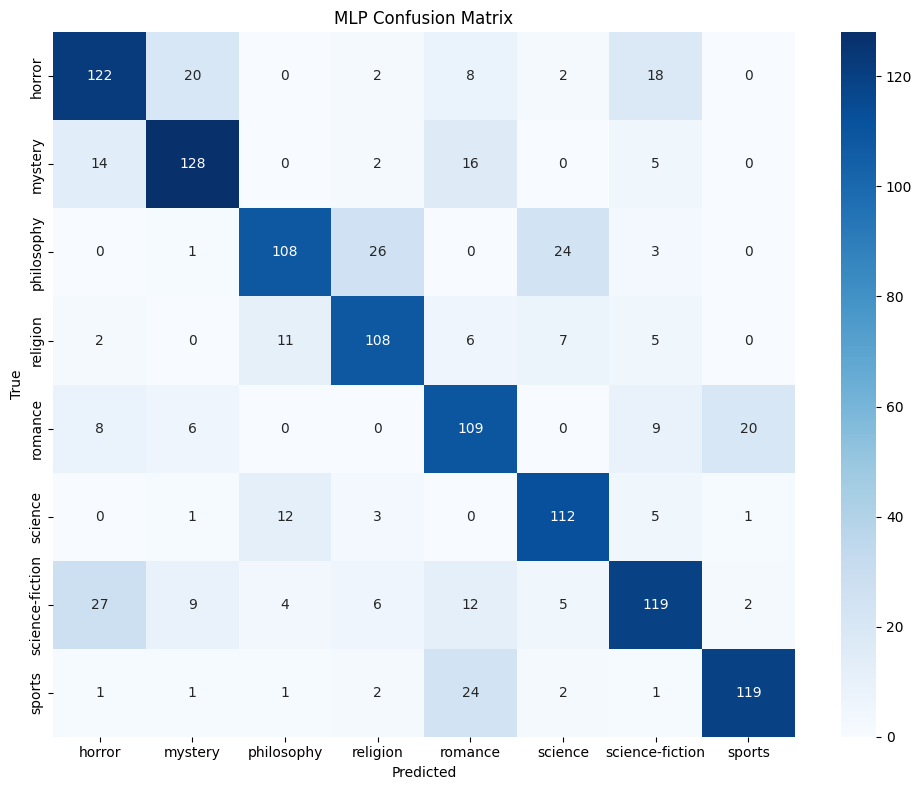

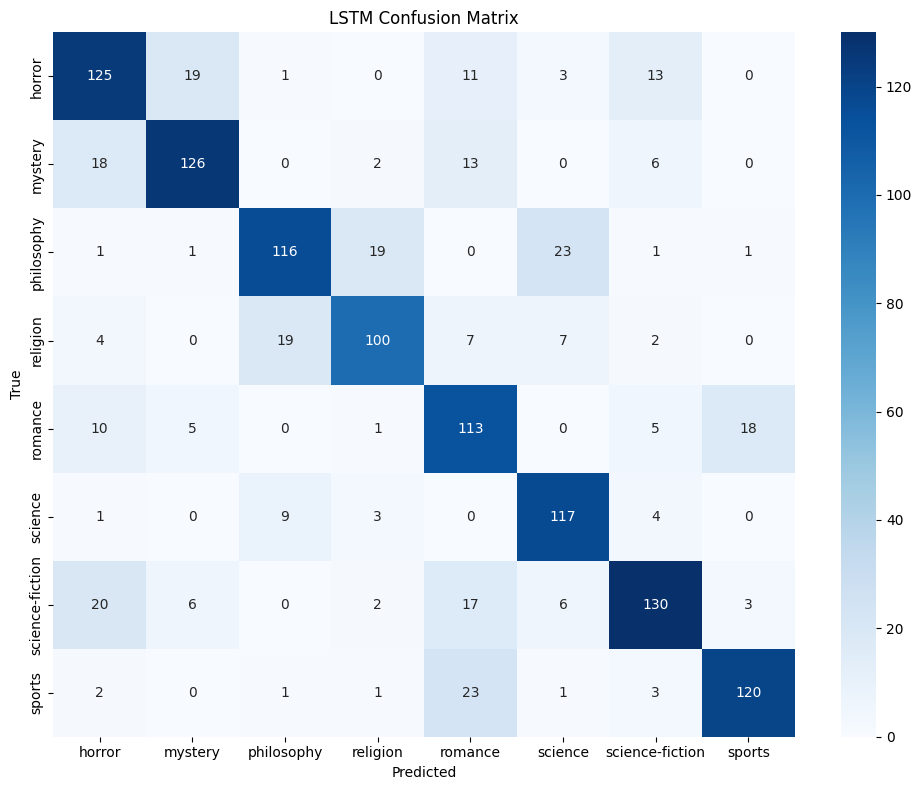

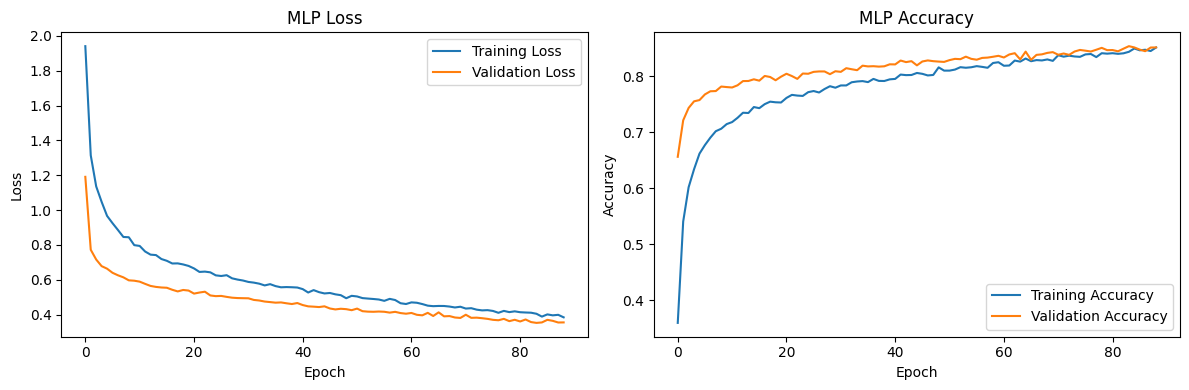

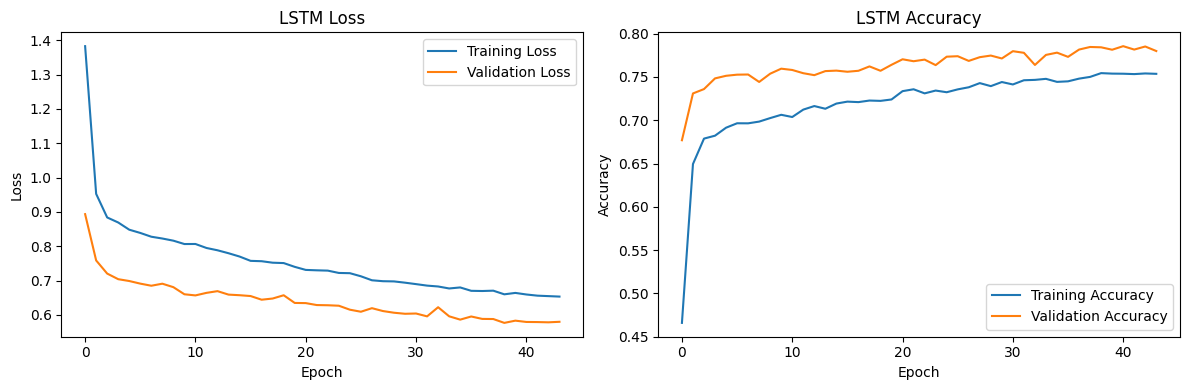

Training and evaluation complete!


In [ ]:

# karmaşıklık matrisi mlp
mlp_cm = confusion_matrix(y_test_labels, mlp_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('mlp_confusion_matrix.png')
plt.show()

# LSTM karmaşıklık matrisi
lstm_cm = confusion_matrix(y_test_labels, lstm_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('lstm_confusion_matrix.png')
plt.show()

# Plot training history
# MLP Plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['loss'], label='Training Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
plt.title('MLP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['accuracy'], label='Training Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('mlp_training_history.png')
plt.show()

# LSTM Plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('lstm_training_history.png')
plt.show()

# modelleri kaydet
mlp_model.save("book_genre_mlp_word2vec.h5")
lstm_model.save("book_genre_lstm_word2vec.h5")

# Bert

## 1. Veri Hazırlama ve Ön İşleme
veri setini okuduktan sonra train ve test olacak şekilde ayırıyoruz.
- Tüm metni küçük harfe dönüştürme
- URL'leri temizleme
- Fazla boşlukları kaldırma

In [ ]:
df = pd.read_csv("book_data.csv")

train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

def preprocess_text(text):
    # küçük harfe çevir
    text = text.lower()
    # linkleri sil
    text = re.sub(r'http\S+', '', text)
    # fazla bışlukları kaldır
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['cleaned_plot'] = train_df['Plot'].apply(preprocess_text)
test_df['cleaned_plot'] = test_df['Plot'].apply(preprocess_text)

## 2. Veri Artırma (Data Augmentation)
Modelin performansını artırmak için veri artırma teknikleri kullanıldı:

1. **Eş Anlamlı Kelime Değiştirme**: WordNet kullanarak metindeki bazı kelimeleri eş anlamlılarıyla değiştirme
2. **Rastgele Silme**: Metinden belirli bir olasılıkla rastgele kelimeleri çıkarma

In [ ]:
# eş anlam
def synonym_replacement(text, n=2):
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_text = aug.augment(text, n=n)
    return augmented_text[0]

# Random silme
def random_deletion(text, p=0.1):
    words = text.split()
    if len(words) <= 1:
        return text
    new_words = [word for word in words if random.uniform(0, 1) > p]
    if len(new_words) == 0:
        return random.choice(words)
    return ' '.join(new_words)


augmented_texts = []
augmented_labels = []


for text, label in zip(train_df['cleaned_plot'], train_df['Genre']):
    # orijinal veriyi ekle
    augmented_texts.append(text)
    augmented_labels.append(label)

    # eş anlamlı veriyi ekle
    aug_text = synonym_replacement(text, n=2)
    augmented_texts.append(aug_text)
    augmented_labels.append(label)

    # rasgele silinen veriyi ekle
    aug_text = random_deletion(text, p=0.1)
    augmented_texts.append(aug_text)
    augmented_labels.append(label)


augmented_df = pd.DataFrame({
    'text': augmented_texts,
    'genre': augmented_labels
})

print(f"Original train data size: {len(train_df)}")
print(f"Augmented data size: {len(augmented_df)}")

# ileride kullanmak için kaydediyoruz
augmented_df.to_csv("augmented_data_bert.csv", index=False)

## 3. BERT Modeli Kullanımı
tokenizerleri başlat ve embedingleri al

In [ ]:
# Tokenizerleri başlat
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# cuda varsa GPU üzerinden çalış
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


def get_bert_embedding(text, max_length=512):
    text = text[:max_length] # Metni maksimum uzunluğa kırp

    # Giriş tensörlerini tokenleştir ve hazırla
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=max_length)

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # BERT gömme vektörlerini al
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

    return embeddings[0]  # numpy dizisi olarak döndür

print("Generating BERT embeddings for training data...")
X_train_val = np.array([get_bert_embedding(text) for text in augmented_df['text']])

print("Generating BERT embeddings for test data...")
X_test = np.array([get_bert_embedding(text) for text in test_df['cleaned_plot']])

## Etiketleri encode et

In [ ]:
# etiketleri sayısala çevir
le = LabelEncoder()
y_train_val = le.fit_transform(augmented_df['genre'])
y_train_val = to_categorical(y_train_val)
y_test = le.transform(test_df['Genre'])
y_test = to_categorical(y_test)

num_classes = y_train_val.shape[1]

## Veri Setini Böl

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

## 4. Model Mimarileri
### 4.1. MLP (Çok Katmanlı Algılayıcı) Modeli
Mimarinin özellikleri:
- 768 boyutlu BERT gömmeleri giriş olarak alıyor
- 512, 256 ve 128 nöronlu üç gizli katman
- Aşırı öğrenmeyi önlemek için Batch Normalization ve Dropout
- Çıkış katmanında softmax aktivasyonu ile tür sınıflandırması

In [ ]:
# erken durdurma
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#  MLP model
mlp_model = Sequential()
mlp_model.add(Input(shape=(768,)))  # BERT embedding dimension is 768
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dropout(0.3))
mlp_model.add(Dense(num_classes, activation='softmax'))

# MLP modeli derle
mlp_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#  MLP modeli eğit
history_mlp = mlp_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

### 4.2. LSTM Modeli
Mimarinin özellikleri:
- BERT gömmelerini sekans olarak işleme (şekil yeniden düzenlenerek)
- İki LSTM katmanı (256 ve 128 birimli)
- Düşme (dropout) ve tekrarlayan düşme (recurrent dropout) ile düzenlileştirme
- Softmax aktivasyonlu çıkış katmanı

In [ ]:
# LSTM için vektörleri uygun hâle getir
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

#  LSTM modeli oluştur
lstm_model = Sequential()
lstm_model.add(Input(shape=(1, 768)))  # BERT embedding dimension is 768
lstm_model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
lstm_model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
lstm_model.add(Dense(num_classes, activation='softmax'))

#  LSTM modeli derle
lstm_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#  LSTM modeli eğit
history_lstm = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_lstm, y_val),
    callbacks=[early_stopping]
)

## 5. Değerlendirme ve Görselleştirme
Modeller çeşitli metriklerle değerlendirildi:
- Doğruluk (Accuracy)
- Kesinlik (Precision)
- Duyarlılık (Recall)
- F1 Skoru

In [ ]:
# tahminler
mlp_pred = np.argmax(mlp_model.predict(X_test), axis=1)
lstm_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Evaluate MLP model
mlp_test_loss, mlp_test_acc = mlp_model.evaluate(X_test, y_test, verbose=0)
mlp_precision = precision_score(y_test_labels, mlp_pred, average='macro')
mlp_recall = recall_score(y_test_labels, mlp_pred, average='macro')
mlp_f1 = f1_score(y_test_labels, mlp_pred, average='macro')

print(f"MLP Test Accuracy: {mlp_test_acc:.4f}")
print(f"MLP Precision: {mlp_precision:.4f}")
print(f"MLP Recall: {mlp_recall:.4f}")
print(f"MLP F1-Score: {mlp_f1:.4f}")

# Evaluate LSTM model
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_lstm, y_test, verbose=0)
lstm_precision = precision_score(y_test_labels, lstm_pred, average='macro')
lstm_recall = recall_score(y_test_labels, lstm_pred, average='macro')
lstm_f1 = f1_score(y_test_labels, lstm_pred, average='macro')

print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")
print(f"LSTM Precision: {lstm_precision:.4f}")
print(f"LSTM Recall: {lstm_recall:.4f}")
print(f"LSTM F1-Score: {lstm_f1:.4f}")

## 6.Sınıf Bazında detaylı Rapor

In [ ]:
print("\nMLP Classification Report:")
print(classification_report(y_test_labels, mlp_pred, target_names=le.classes_))

print("\nLSTM Classification Report:")
print(classification_report(y_test_labels, lstm_pred, target_names=le.classes_))

## 7.Karmaşıklık matrisleri

In [ ]:
# MLP Karmaşıklık Matrisi
mlp_cm = confusion_matrix(y_test_labels, mlp_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('mlp_confusion_matrix_bert.png')
plt.show()

# LSTM Karmaşıklık Matrisi
lstm_cm = confusion_matrix(y_test_labels, lstm_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('lstm_confusion_matrix_bert.png')
plt.show()

## 8.Eğitim Grafikleri

In [ ]:
# Plot training history
# MLP Plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['loss'], label='Training Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
plt.title('MLP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['accuracy'], label='Training Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('mlp_training_history_bert.png')
plt.show()

# LSTM Plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('lstm_training_history_bert.png')
plt.show()

# ileride kulanmak için modeli kaydet
mlp_model.save("book_genre_mlp_bert.h5")
lstm_model.save("book_genre_lstm_bert.h5")

print("Training and evaluation complete!")